# Gözetimsiz öğrenme (Unsupervised Learning): Segmentasyon

Gözetimsiz öğrenme üzerine bugün yapacağımız çalışma bir müşteri RFM (Recency/Frequency/Monetary, Yakınlık/Sıklık/Mali) değer analizi olacak. Bu amaçla da kümeleme yöntemlerinden K-ORtalamalar (KMeans) yöntemini kullanacağız. 

İlk önce gözetimsiz öğrenmenin temellerine bakalım.

Gözetimsiz öğrenmeyi iki boyutlu (iki değişken) bir örnek üzerinden anlatacağım. Ama kavramlar çok boyutlu örneklerde de benzer şekilde genelleştirilebilir. Burada bahsedeceğim yöntemleri çok yüksek boyutlu verilere uygulamak sonuçların anlaşılmasını zorlaştırabilir. Bu nedenle verinin dönüştürülmesini sağlayan yöntemler ile kümeleme birlikte kullanılabilir. 

Aşağıdaki örnekte kaç tane küme ya da grup var?

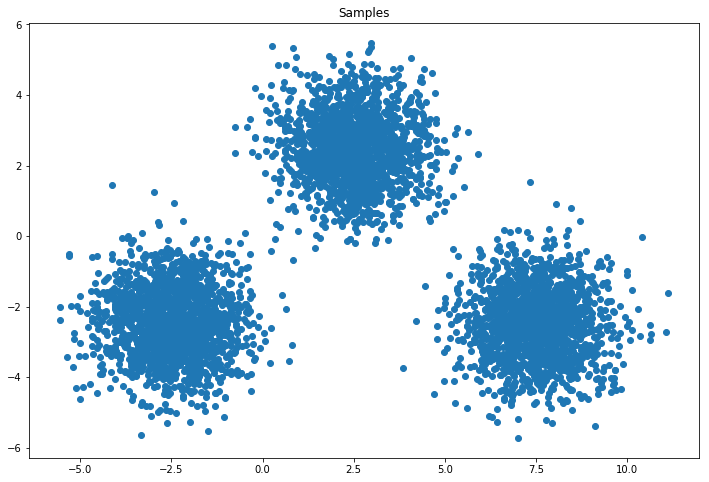

In [1]:
#In order to generate artificial clustering and classification datasets
from sklearn.datasets import make_blobs

import numpy as np

#vKmeans algorithm for clustering
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
# We create a data set using 5000 observations. The dataset has 3 clusters, for which we provide the centers.
# We use make_blobs in order to create the artificial dataset.
n_samples = 5000
centers = [(-2.5, -2.5), (2.5, 2.5), (7.5, -2.5)]
X,y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=1.0, centers=centers, random_state=1)

plt.figure(figsize=(12,8))
plt.scatter(X[:, 0], X[:, 1])
plt.title("Samples")
plt.show()
    

Bu örnekte üç grup var ve bu grupları görselleştirmek gayet kolay. Ancak verinin boyutu arttığında görselleştirerek karar vermek gibi bir opsiyonumuz olmayacak. Bu nedenle gözetimsiz öğrenmeden yararlanacağız. Gözetimsiz öğrenmenin temelleri oldukça kolay olmasına rağmen uygularken çok dikkatli olmamız gerekiyor. Buradaki en büyük sorun küme sayısını önceden belirlemeniz gerekliliği. Vereceğiniz her küme sayısı için bir sonuç almanız, bu sonucun açıklanabilir ya da mantıklı olduğunu göstermiyor. Örnek olarak yukarıdaki gözlemleri farklı şekillerde kümeleyelim.

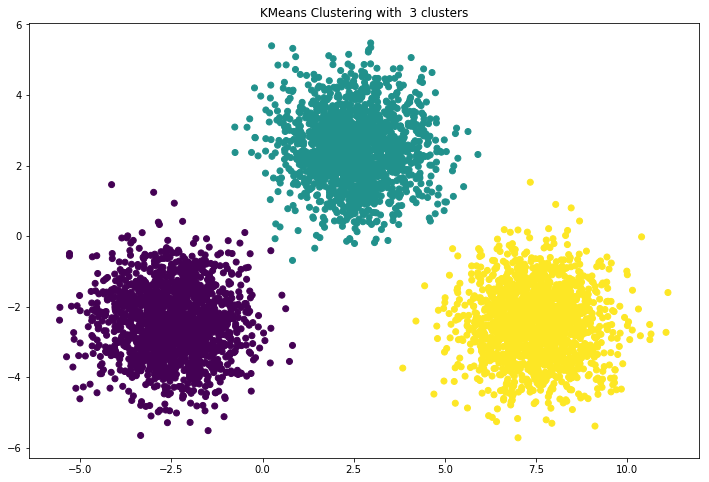

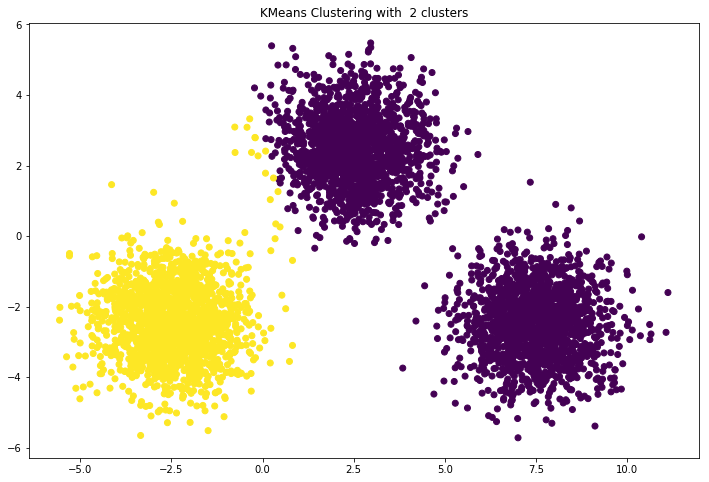

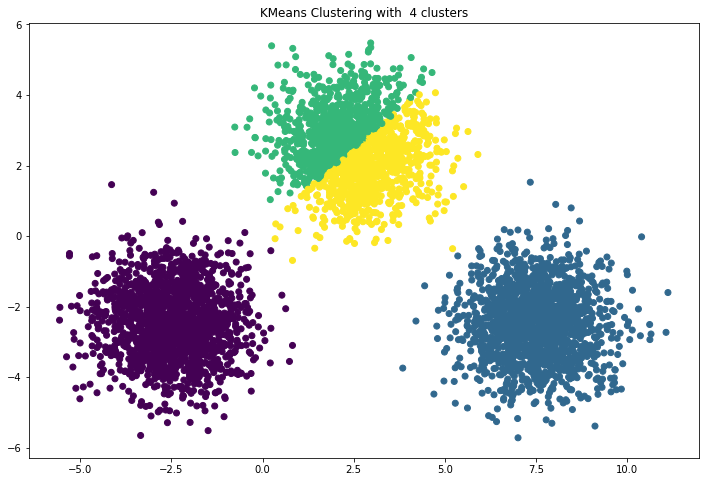

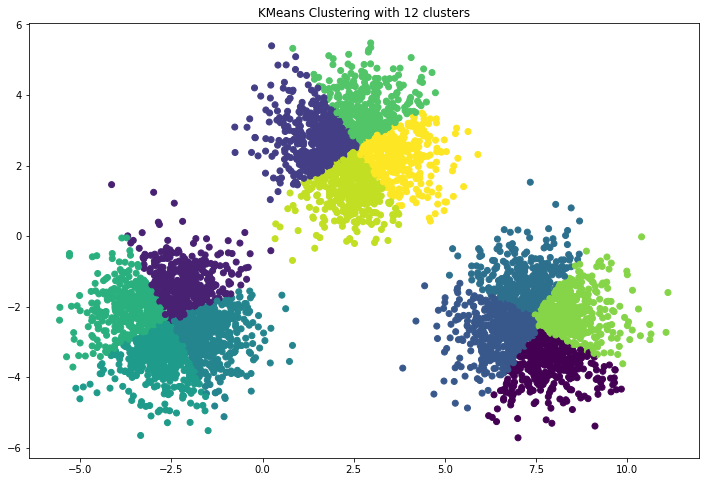

In [2]:
# We try various cluster numbers. Dataset contains 3 clusters by construction
for numberClusters in [3,2,4,12]:
    # We create a k-Means model and train it using dataset we just created.
    # We run the algorithm using 10 different initialization in order to obtain better results.
    kmeans = KMeans(n_clusters=numberClusters, n_init=10)
    # This is the labels that we obtain with KMeans algorithm.
    # We also could have used the following lines
    """
    kmeans.fit(X)
    cluster_labels = kmeans.predict(X)
    """
    cluster_labels= kmeans.fit_predict(X)
    # We plot the dataset (as a scatter plot) and each observation is colored by its cluster number.
    plt.figure(figsize=(12,8))
    plt.scatter(X[:, 0], X[:, 1], c=cluster_labels)
    plt.title("KMeans Clustering with %2i clusters" % numberClusters)
    plt.show()

En iyi küme sayısını seçmekten bahsedeceğiz. Ancak bu aşamada K-Ortalamalar algoritmasını incelemek de yararlı olacakır. K-Ortalamalar algoritması, değişkenlerden oluşan uzayı küme merkezlerine göre parçalar ve karar sınırları belirler. Gözlemler içinde bulundukları karar sınırına göre küme merkezlerine atanır.

Karar sınırlarının belirlenmesi de iteratif olarak gerçekleşir. Her adımda küme merkezleri belirlenir (başta rassal) ve bu kümeye ait gözlemlere göre merkezler güncellenir. BElirli sayıda iterasyondan sonra ya da değişim olmayınca durulur.

Şimdi karar sınırlarını belirleyelim.

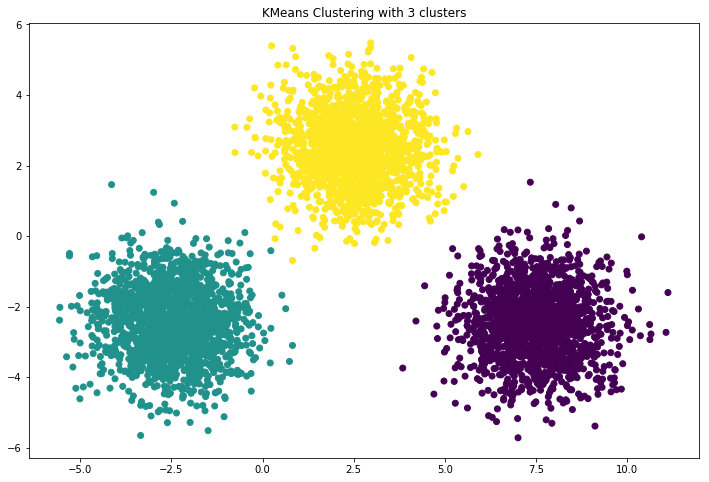

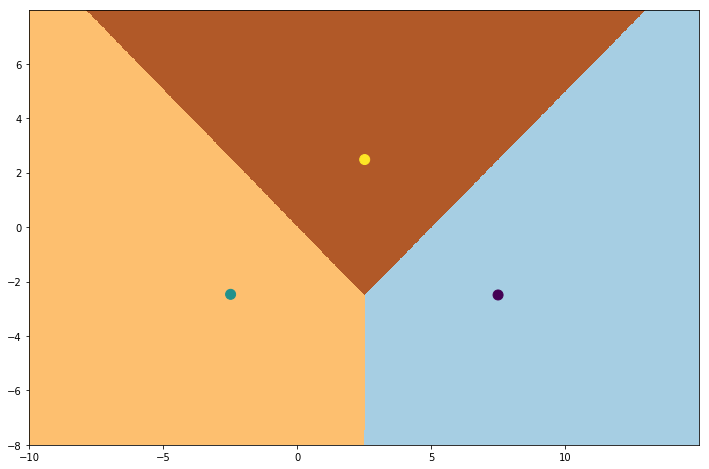

In [3]:
# We draw decision boundaries for clustering using 3 clusters. It allows us to see decision boundaries for clusters.
# We train clustering algorithm and obtain labels for clusters.
# We reinitialize the clustering algorithm using 3 clusters.
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans.fit(X)
labels_3 = kmeans.predict(X)

plt.figure(figsize=(12,8))
plt.scatter(X[:, 0], X[:, 1], c=labels_3)
plt.title("KMeans Clustering with 3 clusters")
plt.show()

"""
In order to see decision boundaries we are going to create a meshgrid. 
x values are between -10 and 15. y values are between -8 and 8.

"""
#Step size of meshgrid
h = .02
xx, yy = np.meshgrid(np.arange(-10, 15, h), np.arange(-8, 8, h))

# What do we use here? Do we use predict or do we fit first?
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
# Use scatter for cluster centers and imshow for the whole area
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c=kmeans.predict(kmeans.cluster_centers_), s=100)
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')
plt.show()

Kümeleme analizinde RFM (Recency/Frequency/Monetary) üzerinden bir kümeşleme yapacağız. 

İlk önce transaction verisini okuyarak başlayalım. Tarih kolonunun tarih (`datetime`) formatına çevirelim.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df= pd.read_csv('Transactions.csv')
df['DATE_OF_TRANSACTION'] = pd.to_datetime(df['DATE_OF_TRANSACTION'])
df.head()

,CUSTOMER_NUMBER,DATE_OF_TRANSACTION,STORE_NUMBER,LANE_NUMBER,TRANSACTION_NUMBER,TIME_OF_TRANSACTION,TOTAL_AMOUNT,BasketID
0,3387044614560516,2015-01-28,1219,8,8021,1250,39.70,15012812190088021
1,2787484677560715,2015-01-04,4129,2,9747,1041,9.25,15010441290029747
2,1587434610560319,2015-01-25,3363,5,8914,1602,1.00,15012533630058914
3,7787884646560115,2015-01-18,2390,2,3547,1620,87.37,15011823900023547
4,7787974693560216,2015-01-27,1242,1,1148,940,5.50,15012712420011148


Verinin özetini alalım.

In [5]:
df.describe()

,CUSTOMER_NUMBER,STORE_NUMBER,LANE_NUMBER,TRANSACTION_NUMBER,TIME_OF_TRANSACTION,TOTAL_AMOUNT,BasketID
count,2.123140e+05,212314.000000,212314.000000,212314.000000,212314.000000,212314.000000,2.123140e+05
mean,5.028285e+15,2439.164996,4.660946,4925.621711,1602.059473,49.424581,1.503710e+16
std,2.839089e+15,1324.727802,4.867279,2886.189664,329.116191,75.271390,1.701512e+13
min,5.032497e+12,69.000000,1.000000,0.000000,0.000000,-1598.000000,1.501010e+16
25%,2.587915e+15,1207.000000,2.000000,2420.000000,1346.000000,12.300000,1.502170e+16
50%,5.087095e+15,2773.000000,3.000000,4888.000000,1637.000000,27.820000,1.504031e+16
75%,7.405922e+15,3593.000000,5.000000,7414.000000,1848.000000,61.250000,1.505171e+16
max,9.988938e+15,4654.000000,54.000000,9999.000000,2358.000000,11798.320000,1.506305e+16


Gördüğümüz gibi, çok yüksek miktarlarda alışveriş içeren fişler ya da negatif tutardaki fişler var. Bunları veriyi toplulaştırdığımızda inceleyeceğiz. Ancak yine de bir `boxplot` ile görselleştirelim.

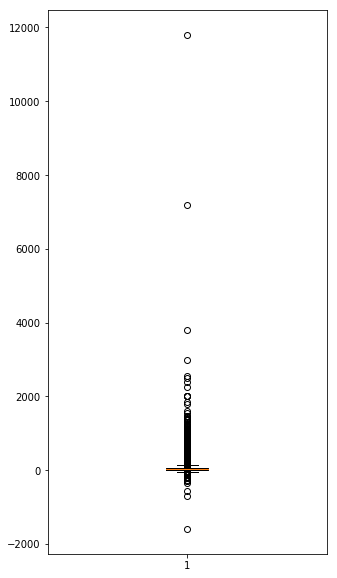

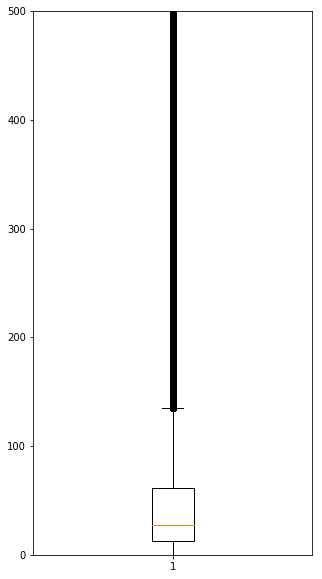

In [6]:
plt.figure(figsize = (5,10))
plt.boxplot(df.TOTAL_AMOUNT)
plt.show()

plt.figure(figsize = (5,10))
plt.boxplot(df.TOTAL_AMOUNT)
plt.ylim((0,500))
plt.show()

Müşterilerin RFM değerlerini nasıl ölçebiliriz?

* Recency: Yakınlık değeri için en son alışverişten bu yana geçen süre kullanılabilir.
* Frequency: Sıklık değeri için alışveriş sayısı (ya da alışveriş yapılan gün sayısı) değişkenleri kullanılabilir.
* Monetary: Maddi değer için toplam alışveriş tutarı kullanılabilir.

Bunları hesaplamak için neye ihtiyacımız var?
* En son alışveriş tarihi (max)
* Alışveriş sayısı (count)
* Alışveriş tutarı (sum)

In [7]:
df_grouped = df.groupby('CUSTOMER_NUMBER').agg({'BasketID': 'nunique', 'TOTAL_AMOUNT':'sum', 'DATE_OF_TRANSACTION': 'max'})
df_grouped.columns = ['Freq', 'Money', 'Rec']
df_grouped.head()

,Freq,Money,Rec
CUSTOMER_NUMBER,,,
5032497241334,30,540.22,2015-06-16
5052441373604,1,14.50,2015-01-04
5432450373319,7,174.92,2015-06-21
5432492249034,3,74.46,2015-04-06
5542430379015,29,2372.17,2015-06-26


Yakınlık değerini de en son alışverişten bu yana geçen gün sayısına çevirelim. En son alışveriş tarihini inceleyelim.

In [8]:
print(df_grouped['Rec'].max())
df_grouped['Rec'] = pd.to_datetime(df_grouped['Rec'].max()) - df_grouped['Rec']
df_grouped['Rec'] = df_grouped['Rec']/np.timedelta64(1,'D')
df_grouped

2015-06-30 00:00:00


,Freq,Money,Rec
CUSTOMER_NUMBER,,,
5032497241334,30,540.22,14.0
5052441373604,1,14.50,177.0
5432450373319,7,174.92,9.0
5432492249034,3,74.46,85.0
5542430379015,29,2372.17,4.0
5542441370429,70,1411.26,0.0
5832420254096,122,7498.77,0.0
5922431370309,1,23.94,104.0
5942436375807,2,334.75,49.0


Şimdi veri setini tekrar inceleyelim.

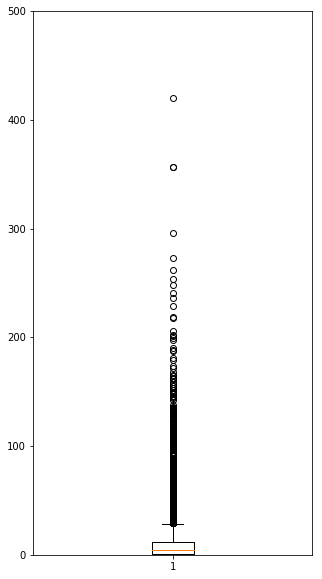

In [9]:
plt.figure(figsize = (5,10))
plt.boxplot(df_grouped['Freq'])
plt.ylim((0,500))
plt.show()

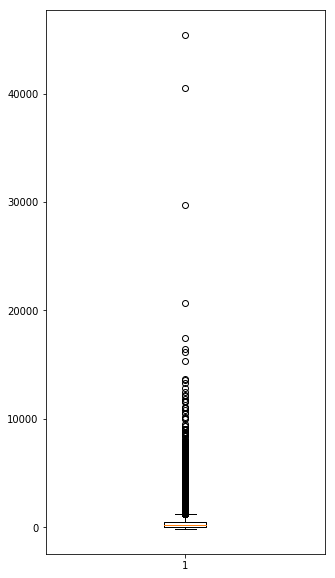

In [10]:
plt.figure(figsize = (5,10))
plt.boxplot(df_grouped['Money'])
plt.show()

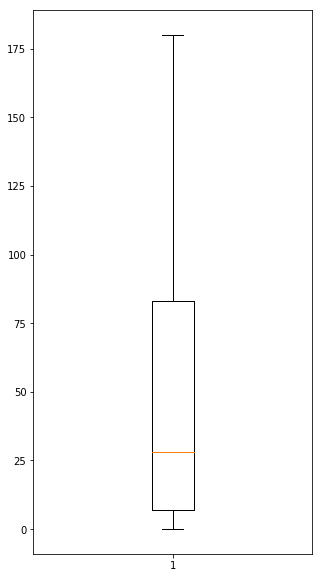

In [11]:
plt.figure(figsize = (5,10))
plt.boxplot(df_grouped['Rec'])
plt.show()

Ben aşağıdaki gibi bir filtre kullanarak veriyi güncelledim. Çok yüksek ve negatif alışverişler, 90 gündür gelmeyen müşteriler, 150'den fazla alışveriş yapmış müşteriler veriden çıkarıldı.

In [12]:
print(len(df_grouped))
df_grouped = df_grouped[df_grouped['Freq'] <=150 ]
print(len(df_grouped))
df_grouped = df_grouped[df_grouped['Money'] <= 10000]
print(len(df_grouped))
df_grouped = df_grouped[df_grouped['Money'] >= 50]
print(len(df_grouped))
df_grouped = df_grouped[df_grouped['Rec'] <= 90]
print(len(df_grouped))

20000
19961
19940
15002
12686


In [13]:
df_grouped.describe()

,Freq,Money,Rec
count,12686.000000,12686.000000,12686.000000
mean,14.827999,740.458527,21.826029
std,18.182062,1056.856155,23.738417
min,1.000000,50.000000,0.000000
25%,4.000000,148.055000,3.000000
50%,8.000000,339.220000,12.000000
75%,18.000000,853.180000,34.000000
max,150.000000,9991.480000,90.000000


Üç küme ile kümeleme analizine başlayalım. KMeans algoritması, Küme merkezleri oluşturarak her gözlemi (müşteri) en yakın küme merkezine atayarak çalışır. Algoritma, her seferinde farklı bir sonuç verebileceği için birden fazla kere çalıştırılarak en iyi sonucun alınması sıklıkla kullanılan bir uygulamadır.

In [14]:
#PAketi yüklüyoruz
from sklearn.cluster import KMeans
#K-ortalamalar modelini oluşturalım. 
kmeans = KMeans(n_clusters = 3, n_init = 10, random_state = 0)

Modeli eğitmek için `fit` fonksiyonunu kullanabiliriz. Gözetimsiz öğrenmede sadece öznitelikler kullanılır, etiket değerleri yoktur. Amaç verinin incelenmesi, gruplara bölünerek birbirine daha fazla benzeyen gözlemlerin birlite kümelenmesidir.

In [15]:
kmeans.fit(df_grouped)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

Şimdi kümelerin merkezlerini ve her kümede kaç gözlem olduğunu görüntüleyelim.

In [16]:
df_cluster_centers = pd.DataFrame(kmeans.cluster_centers_)
df_cluster_centers.columns = ['Freq', 'Money', 'Rec']
a,b = np.unique(kmeans.labels_, return_counts=True)
print(a)
print(b)
print(df_cluster_centers)


[0 1 2]
[ 2146 10042   498]
        Freq        Money        Rec
0  34.121099  1762.472995   8.649278
1   8.787948   325.086490  25.500797
2  53.344689  4700.519018   4.583166


Bu şekilde kümeleri anlamak pek mümkün görünmüyor. `Parallel Plot` ile kümeleri görselleştirelim.

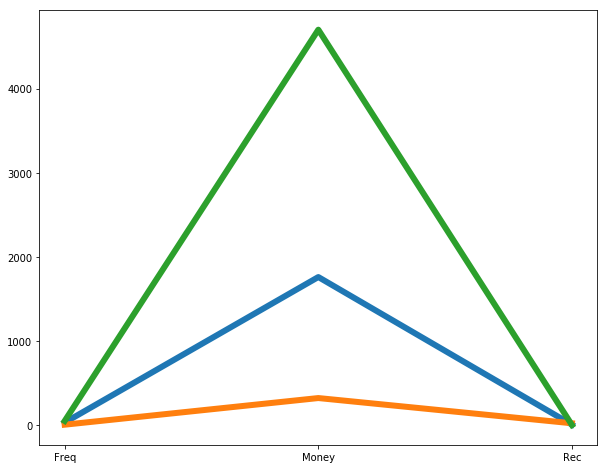

In [17]:
plt.figure(figsize = (10,8))
plt.plot(df_cluster_centers.transpose(), linewidth = 6)
plt.show()

Kümeler sadece mali değer konusunda ayrışmış görünüyor. Aslında gerçek resim bundan biraz farklı. 

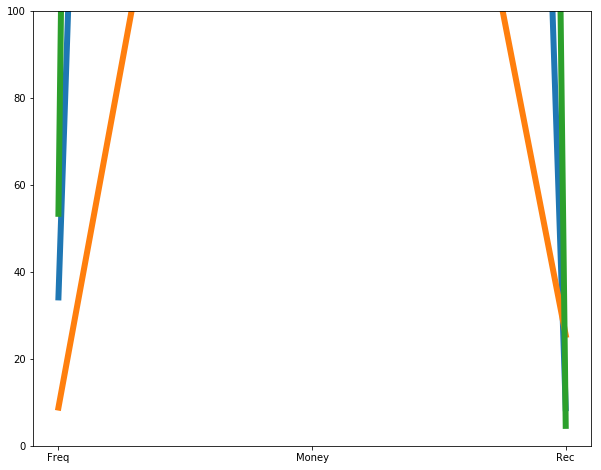

In [18]:
plt.figure(figsize = (10,8))
plt.plot(df_cluster_centers.transpose(), linewidth = 6)
plt.ylim((0,100))
plt.show()

Bu resim aslında tam olarak uyguladığımız yöntemin hatasına işaret ediyor. Veri setindeki maddi değerin altındaki rakamlar çok yüksek olduğu için bu alan kümeleri domine ediyor. Bu nedenle sıklıkla uygulanan ölçeklendirme yöntemlerini kullanmamız faydalı olabilir.

In [19]:
from sklearn.preprocessing import StandardScaler
# Veriyi standart normal dağılıma dönüştürmek amacıyla uygulayacağımız ölçeklendirme modeli.
scaler = StandardScaler()

Veri setini ölçeklendirip modeli tekrar çalıştıralım.

In [20]:
# Veri setini ölçeklendiriyoruz.
df_scaled = scaler.fit_transform(df_grouped)

kmeans = KMeans(n_clusters = 3, n_init = 10, random_state = 0)

kmeans.fit(df_scaled)

C:\Users\byuceoglu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\byuceoglu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

Küme merkezlerini inceleyelim.

       Freq     Money       Rec
0 -0.524538 -0.453503  1.512058
1 -0.183173 -0.219615 -0.469942
2  2.028778  2.068680 -0.721490


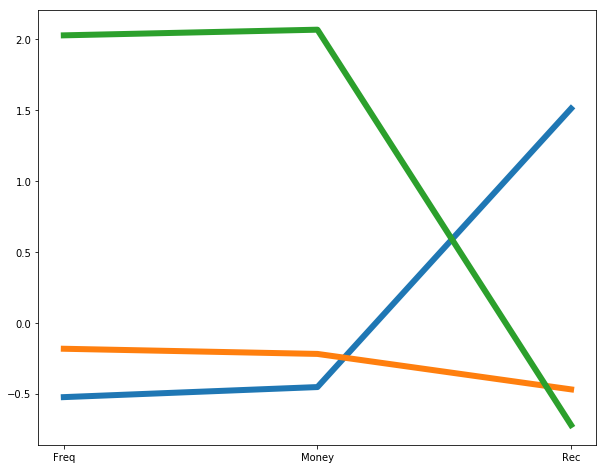

In [21]:
df_cluster_centers = pd.DataFrame(kmeans.cluster_centers_)
df_cluster_centers.columns = ['Freq', 'Money', 'Rec']
print(df_cluster_centers)

plt.figure(figsize = (10,8))
plt.plot(df_cluster_centers.transpose(), linewidth = 6)
plt.show()

Üç küme de birbirinden ayrışıyor gibi duruyor:
* Mavi küme yakın zamanda Migros'a uğramayan müşterilere işaret ediyor.
* Yeşil küme yakın zamanda alışveriş yapmış ve yüksek değerli müşterileri içeriyor.
* Turuncu küme ise daha ortalama örüntüye sahip olan müşterileri gösteriyor.

Veriyi geriye doğru dönüştürerek küme merkezlerini daha yakından inceleyebiliriz.

In [22]:
df_clusters = pd.DataFrame(scaler.inverse_transform(df_cluster_centers), columns=['Freq', 'Money', 'Rec'])
print(df_clusters)

        Freq        Money        Rec
0   5.291199   261.189994  57.718477
1  11.497669   508.365798  10.670782
2  51.713916  2926.669767   4.699676


Kümelerin anlamı ve yapısı biraz değişmiş görünüyor. Kümelerdeki müşteri sayılarını da inceleyelim.

In [23]:
a,b = np.unique(kmeans.labels_, return_counts=True)
print(a)
print(b)

[0 1 2]
[3204 7937 1545]


Farklı küme sayılarıyla analiz tekrar edilebilir. Küme sayısını belirlemek içinse dirsek yöntemi kullanılabilir. Bu yöntemde, istenilen küme sayılarıyla algoritmayı çalıştırıp bir skor elde ederiz. Elde edilen skordaki iyileşmenin düştüğü noktada yeni kümeler oluşturmaya gerek kalmamıştır denilebilir.

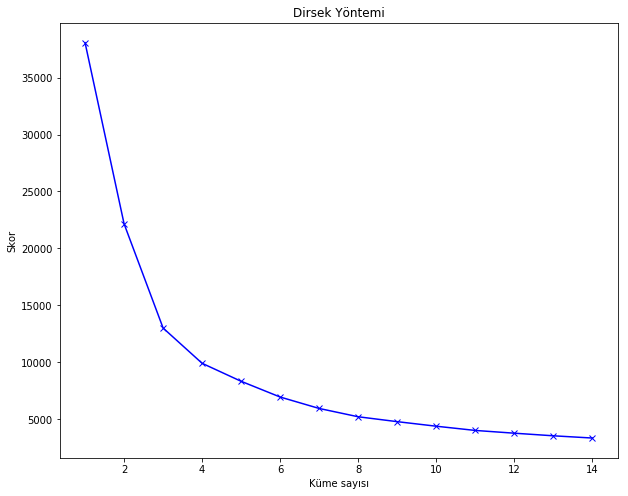

In [24]:
score = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, n_init = 10, random_state = 0)
    km = km.fit(df_scaled)
    score.append(km.inertia_)
    
 
plt.figure(figsize= (10,8))
plt.plot(K, score, 'bx-')
plt.xlabel('Küme sayısı')
plt.ylabel('Skor')
plt.title('Dirsek Yöntemi')
plt.show()

Bu şekle göre 3, 4 ya da 5 küme kullanabiliriz. 4 ve 5 küme ile küme merkezlerine ve müşterilerin kümelere dağılımına bakalım.

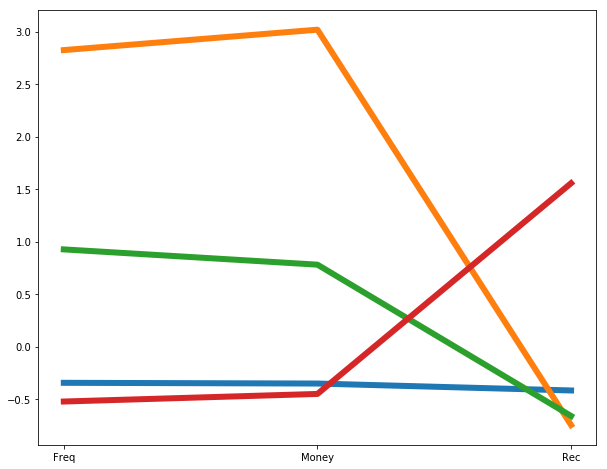

        Freq        Money        Rec
0   8.541015   367.753609  11.887577
1  66.163090  3929.842117   4.071531
2  31.647966  1564.392875   6.120150
3   5.300977   263.070655  58.753746
[0 1 2 3]
[6778  698 2140 3070]


In [25]:
kmeans = KMeans(n_clusters = 4, n_init = 10, random_state = 0)

kmeans.fit(df_scaled)
df_cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=['Freq', 'Money', 'Rec'])
plt.figure(figsize = (10,8))
plt.plot(df_cluster_centers.transpose(), linewidth = 6)
plt.show()
df_clusters = pd.DataFrame(scaler.inverse_transform(df_cluster_centers), columns=['Freq', 'Money', 'Rec'])
print(df_clusters)
a,b = np.unique(kmeans.labels_, return_counts=True)
print(a)
print(b)

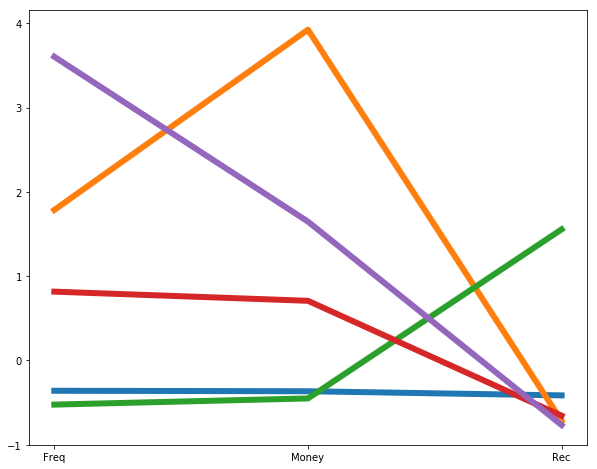

        Freq        Money        Rec
0   8.286987   354.347862  11.987772
1  47.295285  4887.864417   4.803970
2   5.304135   264.188662  58.745685
3  29.670350  1488.387247   6.271179
4  80.341346  2481.602861   3.637019
[0 1 2 3 4]
[6624  401 3071 2173  417]


In [26]:
kmeans = KMeans(n_clusters = 5, n_init = 10, random_state = 0)

kmeans.fit(df_scaled)
df_cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=['Freq', 'Money', 'Rec'])
plt.figure(figsize = (10,8))
plt.plot(df_cluster_centers.transpose(), linewidth = 6)
plt.show()
df_clusters = pd.DataFrame(scaler.inverse_transform(df_cluster_centers), columns=['Freq', 'Money', 'Rec'])
print(df_clusters)
a,b = np.unique(kmeans.labels_, return_counts=True)
print(a)
print(b)

Küme sayısını belirlemek için kümelerin iş hedeflerinizle uyuşup uyuşmadığına, sizin için kümelerdeki müşteri sayısının yeterli olup olmadığına da bakmanız gerekebilir.

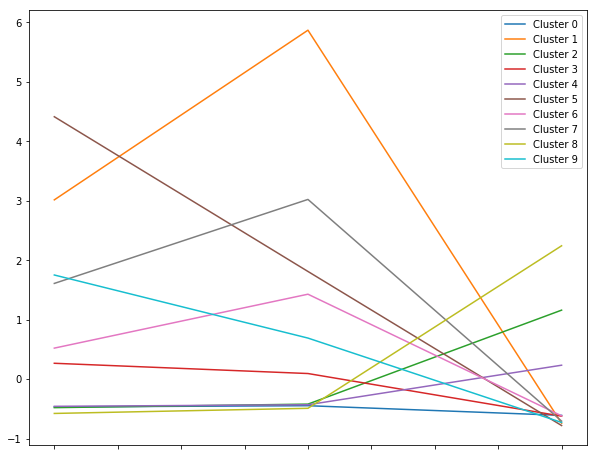

        Freq        Money        Rec
0   6.360406   269.170743   7.384718
1  69.673077  6944.676346   4.240385
2   6.127213   297.379233  49.394754
3  19.696536   841.124808   7.071594
4   6.530497   286.049580  27.409534
5  95.095455  2655.621500   3.322727
6  24.330565  2251.356960   7.192691
7  44.117647  3936.040460   5.092072
8   4.354299   222.855438  75.092357
9  46.694102  1471.373525   4.556927
[0 1 2 3 4 5 6 7 8 9]
[3747  104 1525 2162 1951  220  601  391 1256  729]


In [27]:
kmeans = KMeans(n_clusters=10, n_init = 10, random_state = 0)

kmeans.fit(df_scaled)
df_cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=['Freq', 'Money', 'Rec'])
df_cluster_centers.index = ['Cluster ' + str(i) for i in range(0,10)]
df_cluster_centers.transpose().plot(figsize=(10,8))
plt.show()
df_clusters = pd.DataFrame(scaler.inverse_transform(df_cluster_centers), columns=['Freq', 'Money', 'Rec'])
print(df_clusters)
a,b = np.unique(kmeans.labels_, return_counts=True)
print(a)
print(b)

Bu örnekte turuncu ve gri ile gösterilen ve Monetary değeri en yüksek olan müşteri grupları birbirine oldukça benziyor. Bu grupların ayrışmasına çok gerek yok. Bir tanesi 104 diğeri de 391 gözlemden oluştuğu için bu gruplar birleştirilebilir.